# Exploration of temporal NMS

Based on the papaer: https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2014/data/5209c239.pdf

In [27]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from data import tf_record_loading as loader
from prediction import prediction_utils as predictor
from data import bbox_utils as box

from statistics import get_performance_metrics
from sklearn.metrics import auc

import cv2
import pickle

from procsessing.nms import greedy_nms, soft_nms, t_nms
from data import bbox_utils as box
import visualization
from visualization import draw_circles_from_boxes, plot_circles_from_boxes, write_video
import statistics

In [2]:
# Change default plot size
plt.rcParams['figure.figsize'] = [12, 6]

## Load Model and Data

In [3]:
DATA_PATH = "D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes40.tfrecord"
MODEL_PATH = "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40"

In [4]:
data = loader.load_tf_dataset(DATA_PATH)
model = predictor.load_model(MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Predictions

In [5]:
images = data.get("images")
gt_bboxes = data.get("bboxes")

In [6]:
# predictions = []

# for image in tqdm(images):
#     prediction = predictor.run_inference_for_single_image(model, image)
#     predictions.append(prediction)

predictions = pickle.load(open("predictions.p", "rb"))

## NMS on every image

### Prediction score vs. NMS

In [7]:
first_prediction = predictions[0].get("detection_boxes")[predictions[0].get("detection_scores") >= 0.0]
first_score = predictions[0].get("detection_scores")[predictions[0].get("detection_scores") >= 0.0]

In [8]:
greedy_scores = greedy_nms(first_prediction, first_score, 0.5)
soft_scores = soft_nms(first_prediction, first_score, 0.5)

In [9]:
greedy_predictions = first_prediction[greedy_scores >= 0.5]
soft_predictions = first_prediction[soft_scores >= 0.5]

In [10]:
prediction_points = box.boxes_to_center_points(first_prediction)
greedy_points = box.boxes_to_center_points(greedy_predictions)
soft_points = box.boxes_to_center_points(soft_predictions)

As can be seen in the image below, soft-NMS keeps more predictions. Especially in clustered areas, only the score gets decreased.

In [11]:
img_threshold = visualization.draw_circles_on_image(images[0], prediction_points[first_score >= 0.5], colors=first_score[first_score >= 0.5])
img_nms_vs_soft = visualization.draw_circles_on_image(images[0], soft_points, greedy_points)
img_nms_scores = visualization.draw_circles_on_image(images[0], greedy_points, colors=greedy_scores[greedy_scores >= 0.5])
img_soft_scores = visualization.draw_circles_on_image(images[0], soft_points, colors=soft_scores[soft_scores >= 0.5])

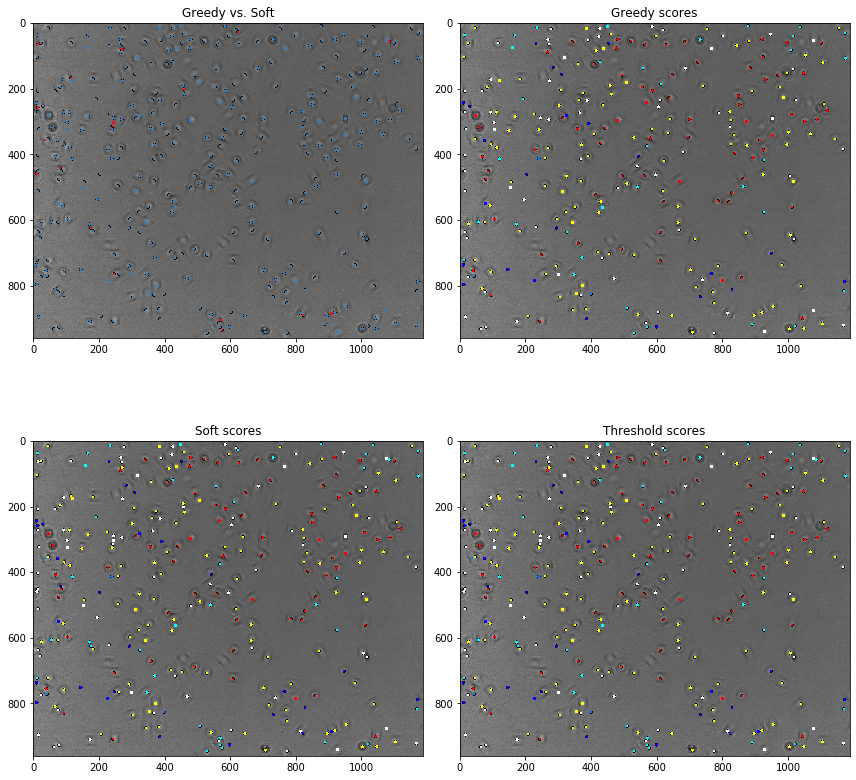

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0, 0].set_title("Greedy vs. Soft")
axs[0, 0].imshow(img_nms_vs_soft)

axs[0, 1].set_title("Greedy scores")
axs[0, 1].imshow(img_nms_scores)

axs[1, 0].set_title("Soft scores")
axs[1, 0].imshow(img_soft_scores)

axs[1, 1].set_title("Threshold scores")
axs[1, 1].imshow(img_threshold)

fig.tight_layout()
plt.show()

## Temporal NMS

In [61]:
# Get all predicitons

all_detections = [x.get("detection_boxes") for x in predictions]
all_scores = [x.get("detection_scores") for x in predictions]

t_detections, t_scores = t_nms(all_detections, all_scores, iou=0.4)

In [62]:
# Save predictions as videos

# g = (draw_circles_from_boxes(image, detection[score >= 0.7]) for image, detection, score in zip(images, t_detections, t_scores))
# write_video(g, "temporal.avi")

# g = (draw_circles_from_boxes(image, detection[score >= 0.7]) for image, detection, score in zip(images, t_detections, t_scores))
# write_video(g, "normal.avi")

## Evaluate tNMS

In [71]:
greedy_scores = [greedy_nms(p, s, 0.5) for p, s in zip(all_detections, all_scores)]
greedy_detecions = [p[s >= 0.7] for p, s in zip(all_detections, greedy_scores)]

soft_scores = [soft_nms(p, s, 0.5) for p, s in zip(all_detections, all_scores)]
soft_detecions = [p[s >= 0.7] for p, s in zip(all_detections, soft_scores)]

In [77]:
evaluation_metrics = {
    "greedy": [],
    "soft": [],
    "temporal": [],
    "plain": []
}


thresh = 0.7

for i in tqdm(range(len(images))):
    
    greedy_score, soft_score = greedy_scores[i], soft_scores[i]
    t_detection, t_score = t_detections[i], t_scores[i]
    all_detection, all_score = all_detections[i], all_scores[i]
    
    greedy = get_performance_metrics(all_detection[greedy_score >= thresh], gt_bboxes[i], 0.5)
    soft = get_performance_metrics(all_detection[soft_score >= thresh], gt_bboxes[i], 0.5)
    temporal = get_performance_metrics(t_detection[t_score >= thresh], gt_bboxes[i], 0.5)
    plain = get_performance_metrics(all_detection[all_score >= thresh], gt_bboxes[i], 0.5)
    
    
    evaluation_metrics.get("greedy").append(greedy)
    evaluation_metrics.get("soft").append(soft)
    evaluation_metrics.get("temporal").append(temporal)
    evaluation_metrics.get("plain").append(plain)

100%|█████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.75it/s]


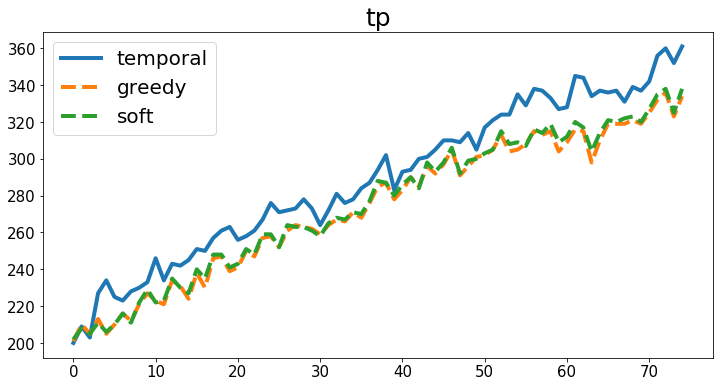

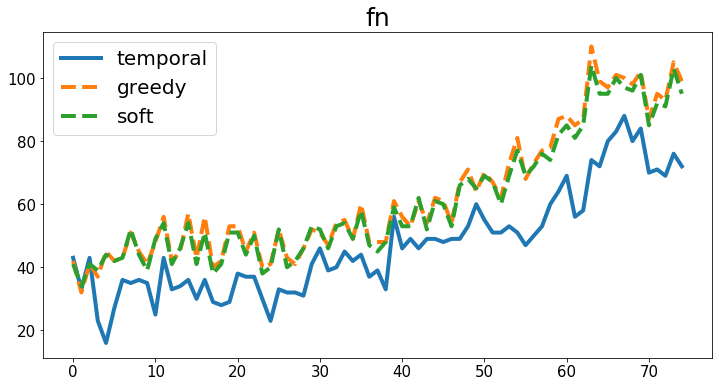

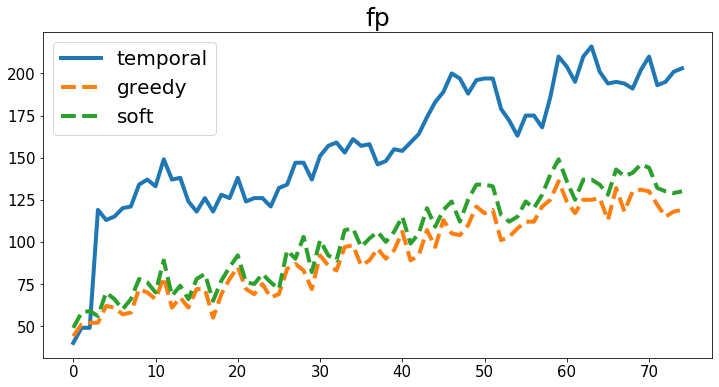

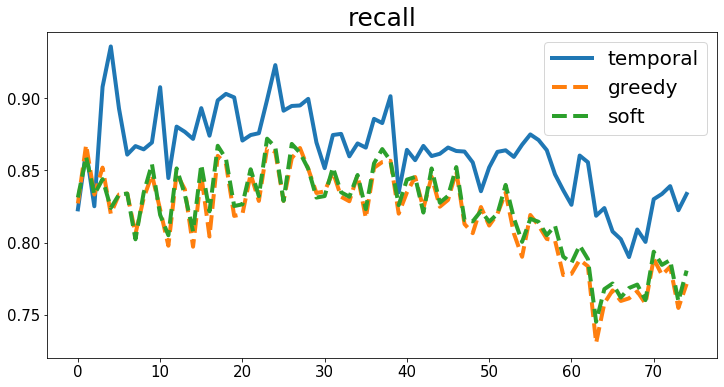

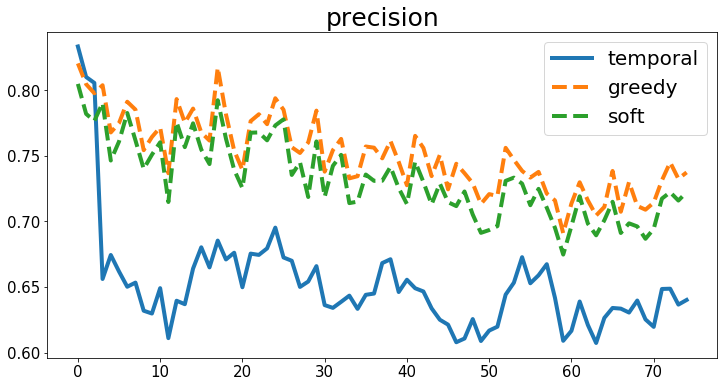

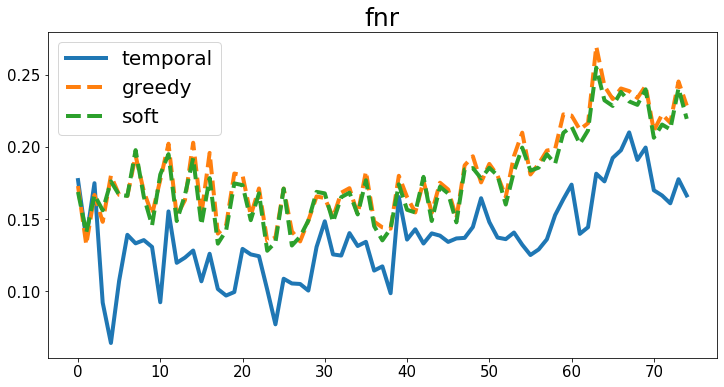

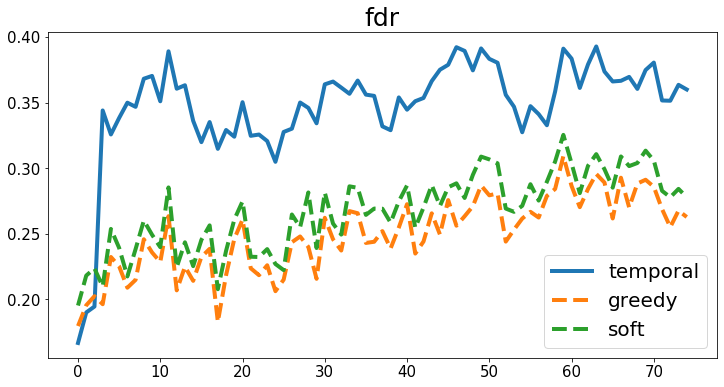

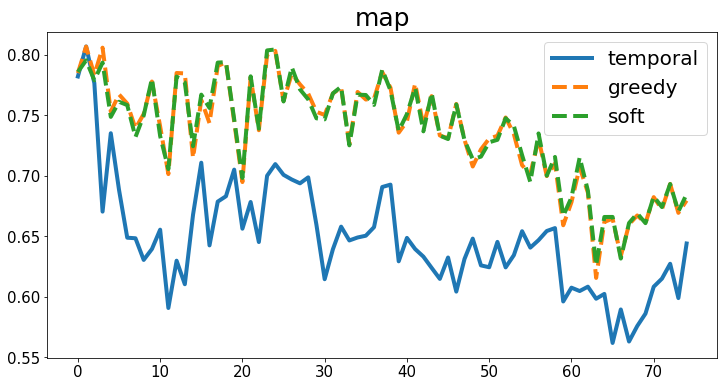

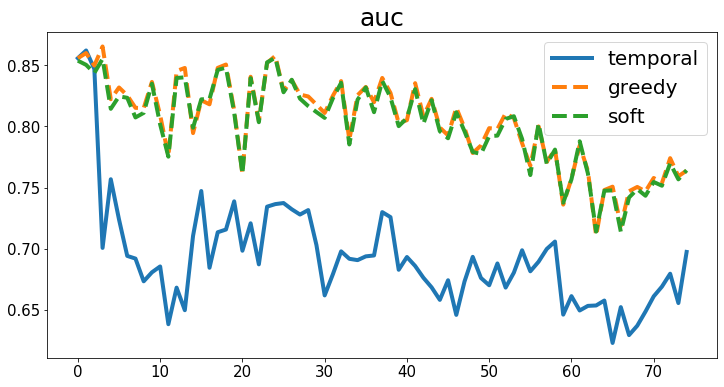

In [93]:
for key in evaluation_metrics.get("soft")[0].keys():
    
    if key in ["recalls", "precisions"]:
        continue
    
    temporal = [evaluation_metrics.get("temporal")[i].get(key) for i in range(len(images))]
    plain = [evaluation_metrics.get("plain")[i].get(key) for i in range(len(images))]
    greedy = [evaluation_metrics.get("greedy")[i].get(key) for i in range(len(images))]
    soft = [evaluation_metrics.get("soft")[i].get(key) for i in range(len(images))]
    
    plt.title(key, fontsize=25)
    plt.plot(temporal, label="temporal", lw=4, linestyle="-")
#     plt.plot(plain, label="plain")
    plt.plot(greedy, label="greedy", lw=4, linestyle="--")
    plt.plot(soft, label="soft", lw=4, linestyle="--")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()